# Task

You are given a set of images that are classified by a model trained on Imagenet as goldfish (class 1). Your task is to compute a strip of pixels of size
10 x 100 (i.e., the first 10 rows of an image of size 100 x 100), which when pasted into *each* of the original images makes the model think it is a shark (class 2) with returned probability of at least 0.5.

Note: you can score half of the points in this task if you compute a strip that works for at least one image from the list.

Important: your code needs to compute the desired strip in at most 2 minutes - it is possible to do it in less than 10 seconds on colab with GPU.


## Data

Below you can find a piece of code that download a zipfile and displays the images. Note that here the images are in their original resolution that will be later scaled down to 100 x 100.

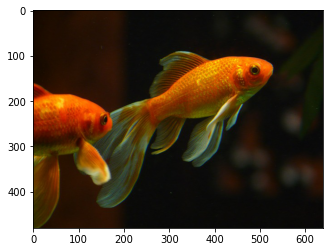

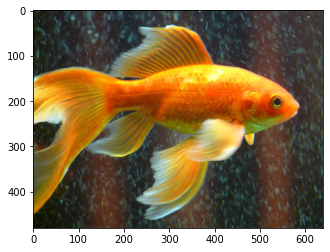

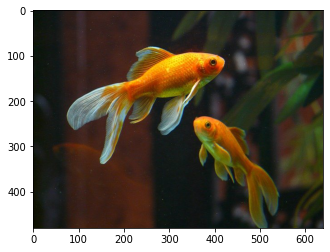

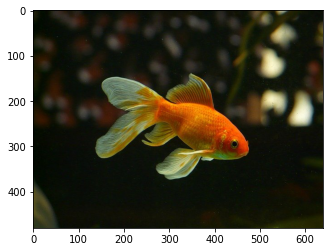

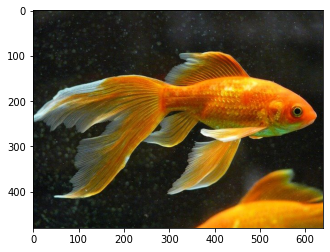

In [ ]:
import requests, zipfile
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

url = "https://www.mimuw.edu.pl/~cygan/goldfish.zip"
request = requests.get(url)
zipfile = zipfile.ZipFile(BytesIO(request.content))
images = []
for filename in zipfile.namelist():
  if filename.endswith('jpg'):
    ifile = zipfile.open(filename)
    img = Image.open(ifile)
    images.append(img)
    plt.imshow(img)
    plt.show()
    

## Model

We will be using the `mobilenet_v2` model, solving the classification problem on the Imagenet dataset. As far as this task is concerned you do not have to know the details of the model's architecture, we are treating it as a black box, in particular the model's weights will be frozen and cannot be changed.



In [ ]:
from torchvision.models import mobilenet_v2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = mobilenet_v2(pretrained=True)
model.to(device)
model.eval()

cuda:0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

## Data preprocessing

In order to evaluate the model on the given images, we first scale them down to size 100x100 (which is an arbitrary choice selected for this task), but also normalize them using the following normalization transform.


In [ ]:
normalize_colors = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

SIZE = 100
resize = transforms.Compose([transforms.Resize((SIZE, SIZE)), 
                             transforms.ToTensor()])

## Evaluation

Below is a piece of code that takes an input a given image and a tensor of size 3x10x100 with values between 0 and 1, and:
* rescales the image to size 100x100,
* replaces the first chunk of size 10x100 by the given tensor (for all 3 colors),
* normalizes the colors of the obtained image,
* evaluates the model and returns the probabilities of the image being classified as goldfish and shark respectively.

In [ ]:
STRIP_HEIGHT = 10

def calc_predictions(image, strip):
  assert strip.shape == (3, STRIP_HEIGHT, SIZE) 
  assert torch.ge(strip, 0.).all()
  assert torch.le(strip, 1.0).all()
  img_tensor = resize(image.convert("RGB")).to(device)
  # At this point img_tensor is of shape (3, SIZE, SIZE)
  ############# Important line - replacing part of the image ################
  img_tensor[:, :STRIP_HEIGHT, :] = strip.to(device)
  img_tensor = normalize_colors(img_tensor)
  # We have to add one more dimention representing the bath.
  img_tensor = img_tensor.unsqueeze(0)
  probabilities = torch.nn.functional.softmax(model(img_tensor)[0])
  # Class 1 in Imagenet is a goldfish, 2 is a shark
  return probabilities[1], probabilities[2]

In [ ]:
for im in images:
  p_goldfish, p_shark = calc_predictions(im, torch.zeros((3, STRIP_HEIGHT, SIZE)))
  print(f'Probability of being a goldfish is {p_goldfish}, shark is {p_shark}.')

Probability of being a goldfish is 0.9992343187332153, shark is 8.080787775033293e-12.
Probability of being a goldfish is 0.9996770620346069, shark is 5.121571569621786e-13.
Probability of being a goldfish is 0.9534572958946228, shark is 2.830801912323544e-11.
Probability of being a goldfish is 0.9590185284614563, shark is 2.0169987641899256e-12.
Probability of being a goldfish is 0.9979506134986877, shark is 2.428032005053621e-13.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


## TO IMPLEMENT

Here you have to implement the function that finds the strip. Please don't modify the name of the function, as later it will be automatically tested.


In [ ]:
def calculate_strip():
  ## TODO
  return torch.zeros((3, STRIP_HEIGHT, SIZE))

 
strip = calculate_strip()
for im in images:
  p_goldfish, p_shark = calc_predictions(im, strip)
  print(f'Probability of being a goldfish is {p_goldfish}, shark is {p_shark}.')

Probability of being a goldfish is 0.9992343187332153, shark is 8.080787775033293e-12.
Probability of being a goldfish is 0.9996770620346069, shark is 5.121571569621786e-13.
Probability of being a goldfish is 0.9534572958946228, shark is 2.830801912323544e-11.
Probability of being a goldfish is 0.9590185284614563, shark is 2.0169987641899256e-12.
Probability of being a goldfish is 0.9979506134986877, shark is 2.428032005053621e-13.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
